In [1]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt

Note:
The nature of datasets can be explicit and any observer using this for information is advised that the use of this public dataset was not censored in any way. That being said, it does not break any rules of being a well established public dataset resource.
This notebook uses a custom __init__.py within tensorflow that allows autocompletion by adding lines to the end of the script -- see https://stackoverflow.com/questions/68860879/vscode-keras-intellisensesuggestion-not-working-properly


In [2]:
physical_devices = tf.config.list_physical_devices()

In [3]:
tf.config.set_visible_devices(physical_devices[:1])

Inspect our public dataset and load it into memory

In [4]:
def load_data(fn:str):
    txt_path = os.path.join(os.getcwd(), "..", "datasets", "emotions", fn)

    res = {}
    with open(txt_path) as f:
        lines = f.readlines()
        for line in lines:
            line_split = line.split(";")
            line, emotion = line_split
            res[line] = emotion.strip()
    return res


In [5]:
data = load_data("train.txt")
data_iter = iter(data)
for i in range(5):
    sample_k = next(data_iter)
    print(sample_k, ", ", data[sample_k])

i didnt feel humiliated ,  sadness
i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake ,  sadness
im grabbing a minute to post i feel greedy wrong ,  anger
i am ever feeling nostalgic about the fireplace i will know that it is still on the property ,  love
i am feeling grouchy ,  anger


In [6]:
print(set(data.values()))

{'sadness', 'anger', 'joy', 'fear', 'surprise', 'love'}


In [7]:
def one_hot_encode_values_map_fn(data_map):
    unique_values = set(data_map.values())
    n = len(unique_values)
    encoded_values_to_float = {}
    for i, val in enumerate(unique_values):
        encoded_values_to_float[val] = i / (n - 1)
    return encoded_values_to_float

def one_hot_encode_values(data_map, values_map):
    for k, v in data_map.items():
        data_map[k] = values_map[v]
    return data_map

In [8]:
one_hot_encoded_values_map = one_hot_encode_values_map_fn(data)
one_hot_encode_values(data, one_hot_encoded_values_map)
pass

In [9]:
data_test = load_data("test.txt")
one_hot_encoded_values_map = one_hot_encode_values_map_fn(data_test)
one_hot_encode_values(data_test, one_hot_encoded_values_map)
pass

Observations: Clearly the labeling process had ambiguities -- there is no clear seperation here between conversational and mood.
Will still try to work with this dataset then speculate when appropriate.

Since all our data fits in memory and the dataset isn't enormous this should train relatively quickly

Create our naive nlp model without too many optimizations

In [10]:
VOCAB_SIZE = 1500
encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE)
encoder.adapt(list(data.keys()))

In [11]:
vocab = np.array(encoder.get_vocabulary())

In [12]:
vocab[:20]

array(['', '[UNK]', 'i', 'feel', 'and', 'to', 'the', 'a', 'feeling',
       'that', 'of', 'my', 'in', 'it', 'like', 'so', 'im', 'for', 'me',
       'but'], dtype='<U13')

In [13]:
encoded_line = encoder(sample_k)
print(encoded_line, '\n', sample_k)

tf.Tensor([   2   24    8 1086], shape=(4,), dtype=int64) 
 i am feeling grouchy


In [14]:

def create_original(encoded_line: tf.Tensor):
    round_trip = []
    for num in encoded_line.numpy():
        round_trip.append(vocab[num])
    return " ".join(round_trip)

def show_samples(n, iter):
    for i in range(n):
        gt_str = next(iter)
        encoded_line = encoder(gt_str)
        print(encoded_line.numpy())
        original = create_original(encoded_line)
        print(original)
        print(gt_str)

In [15]:
show_samples(4, data_iter)

[ 73  48   8   7  56 527 320 328 160 161   9  20]
ive been feeling a little burdened lately wasnt sure why that was
ive been feeling a little burdened lately wasnt sure why that was
[  73   48  331   35    1   35  196    1  901    4   73    1 1427    7
  159    1   19    2  118    3   14   15  461]
ive been taking or [UNK] or times [UNK] amount and ive [UNK] asleep a lot [UNK] but i also feel like so funny
ive been taking or milligrams or times recommended amount and ive fallen asleep a lot faster but i also feel like so funny
[  2   3  29 447  27  78  29   7   1  35  29 762  29   7 193 268 373]
i feel as confused about life as a [UNK] or as jaded as a year old man
i feel as confused about life as a teenager or as jaded as a year old man
[   2   21   48   25    1   17  216    2    3    9    1   99    1  136
    4  132    7 1045    1]
i have been with [UNK] for years i feel that [UNK] has [UNK] well and made a huge [UNK]
i have been with petronas for years i feel that petronas has perfo

Our TextVectorization layer adapted and encoded our strings for us

In [16]:
def create_model():
    input = tf.keras.Input((1,), dtype=tf.dtypes.string)
    layer = encoder(input)
    layer = tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary()),
                                      output_dim=64,
                                      mask_zero=True)(layer)
    layer = tf.keras.layers.Bidirectional(layer=tf.keras.layers.LSTM(units=64))(layer)
    layer = tf.keras.layers.Dense(64, activation="relu")(layer)
    layer = tf.keras.layers.Dense(1)(layer)

    return tf.keras.Model(inputs=input, outputs=layer, name="nlp_rnn_classifier")

In [17]:
model = create_model()

In [18]:
model

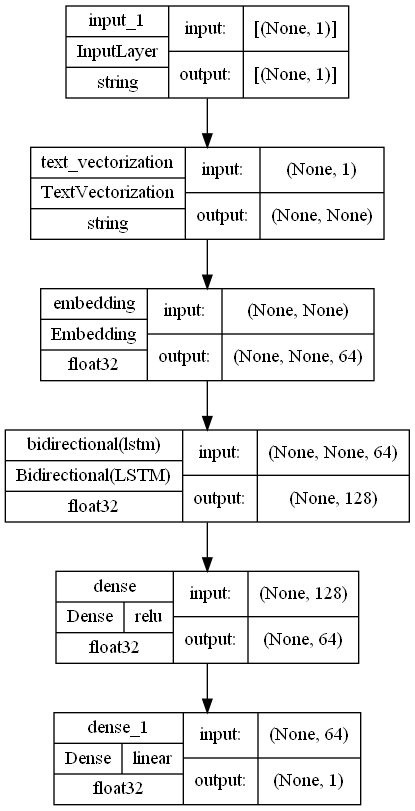

In [19]:
tf.keras.utils.plot_model(model,
                          show_shapes=True,
                          expand_nested=True,
                          show_layer_activations=True,
                          show_dtype=True)

In [20]:
sample_text = "the sun was shining and i am in a happy mood."

In [21]:
np.array([sample_text])

array(['the sun was shining and i am in a happy mood.'], dtype='<U45')

In [22]:
predictions = model.predict(np.array([sample_text]))

1/1 [==============================] - 1s 1s/step


In [23]:
predictions

array([[-0.00156119]], dtype=float32)

In [24]:
print([layer.supports_masking for layer in model.layers])

[True, False, True, True, True, True]


In [25]:
# Multi-label classification
loss_function = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# not too afraid of the gradients with this dataset
optimizer = tf.keras.optimizers.Adam(0.001)

In [26]:
model.compile(loss=loss_function,
              optimizer=optimizer,
              metrics=['accuracy'])

In [27]:
history = model.fit(x=tf.convert_to_tensor(np.asarray(list(data.keys()))),
                    y=tf.convert_to_tensor(np.asarray(list(data.values()))),
                    validation_data=(list(data_test.keys()), list(data_test.values())),
                    validation_steps=30,
                    epochs=10)

Epoch 1/10
500/500 [==============================] - 16s 24ms/step - loss: 0.5435 - accuracy: 0.3226 - val_loss: 0.4899 - val_accuracy: 0.3480
Epoch 2/10
500/500 [==============================] - 9s 17ms/step - loss: 0.4640 - accuracy: 0.3586 - val_loss: 0.4692 - val_accuracy: 0.3535
Epoch 3/10
500/500 [==============================] - 9s 17ms/step - loss: 0.4456 - accuracy: 0.3634 - val_loss: 0.4642 - val_accuracy: 0.3565
Epoch 4/10
500/500 [==============================] - 10s 19ms/step - loss: 0.4370 - accuracy: 0.3654 - val_loss: 0.4628 - val_accuracy: 0.3520
Epoch 5/10
500/500 [==============================] - 10s 19ms/step - loss: 0.4285 - accuracy: 0.3663 - val_loss: 0.4840 - val_accuracy: 0.3555
Epoch 6/10
500/500 [==============================] - 10s 20ms/step - loss: 0.4248 - accuracy: 0.3670 - val_loss: 0.4732 - val_accuracy: 0.3615
Epoch 7/10
500/500 [==============================] - 10s 20ms/step - loss: 0.4193 - accuracy: 0.3677 - val_loss: 0.4716 - val_accuracy: 0

In [28]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

(0.0, 0.3717421188950539)

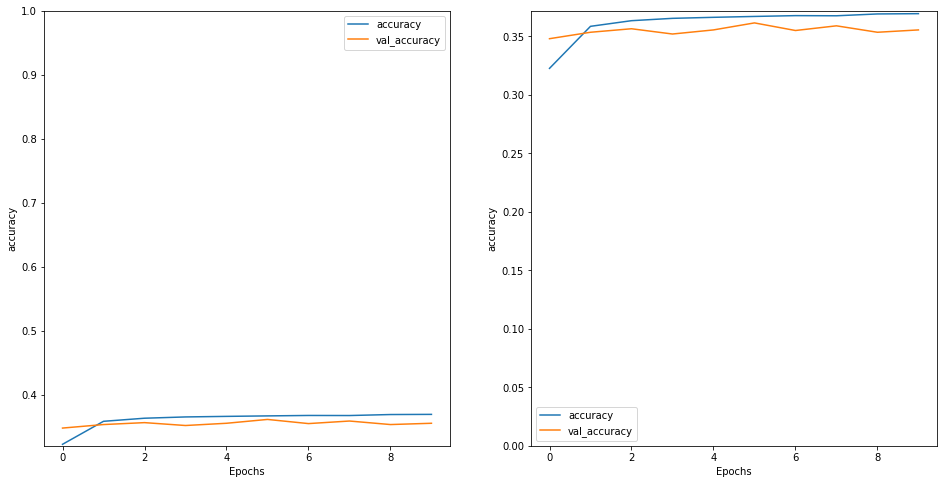

In [29]:
plt.figure(figsize=(16,8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'accuracy')
plt.ylim(0, None)